# 1ère Approche : Plusieurs modèles de régression intra-clusters
* Preprocessing
    * One Hot Encoding sur Gare
    * Drop Commentaire
    * Standardize
* Création des clusters et assignation du *ClusterLabel*
    * Création des 4 clusters avec Kmeans
    * Modèle d'**attribution** de cluster à partir de true_X_features (classification supervisé)
* Prédiction des retards avec 1 modèle/cluster
    * Entrainement d'un modèle de régression (**prédiction** du retard) à partir de true_X_features
    * Concaténation des 2 modèles (**Attribution + Prédiction**)
    * Résultat et comparaison RF & XGB

In [42]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Initial Data Loading
path_parent = os.path.dirname(os.getcwd()) 
path = os.path.join(path_parent, "data", "preprocessed_tgv_data.csv")
df = pd.read_csv(path, delimiter=';')
df = df.reset_index(drop=True)

# Data Preprocessing
commentaire_columns = [com for com in df.columns if 'commentaire' in com]
df.drop(columns=commentaire_columns, inplace=True)
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
df_encoded = pd.get_dummies(df, columns=['gare_depart', 'gare_arrivee'])
cols_for_cluster_assignment = ['year', 'month', 'duree_standard'] + [col for col in df_encoded.columns if 'gare_' in col] # Les vrais X features

# Split Data
df = df_encoded.sample(frac=1, random_state=1)  
train, test = train_test_split(df, test_size=0.2, random_state=42)



numeric_cols = [
    'duree_moyenne', 'duree_standard', 'nb_train_prevu', 'nb_annulation',
    'nb_train_depart_retard', 'retard_moyen_depart',
    'nb_train_retard_arrivee', 'retard_moyen_arrivee',
    'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
    'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
    'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
    'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
    'prct_cause_prise_en_charge_voyageurs'
]

cols_causes = [ 'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
    'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
    'prct_cause_prise_en_charge_voyageurs']

data_for_clustering = train[numeric_cols].copy()
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols].copy())
data_for_clustering_normalized = scaler.fit_transform(data_for_clustering)


true_X_features = cols_for_cluster_assignment
true_y_features =  ['retard_moyen_arrivee']+cols_causes



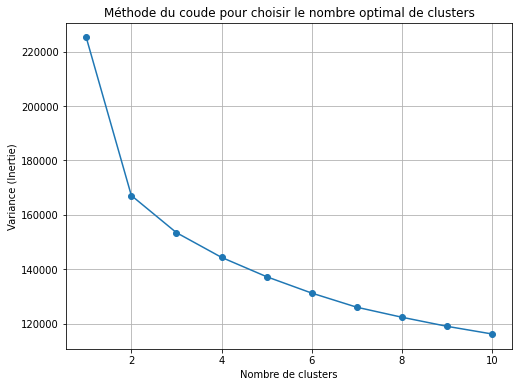

In [43]:
def find_optimal_clusters(data, max_clusters=10):
    distortions = []  # Liste pour stocker les valeurs de distorsion (variance)
    
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, init='random', n_init='auto')
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)  # Inertie du modèle (mesure de la variance)

    # Tracer le graphique de la variance en fonction du nombre de clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Méthode du coude pour choisir le nombre optimal de clusters')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Variance (Inertie)')
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
data = train[cols_for_cluster_assignment + numeric_cols]
find_optimal_clusters(data, max_clusters=10)

In [44]:
# Clustering
NBR_CLUSTERS = 4

kmeans = KMeans(n_clusters=NBR_CLUSTERS, random_state=42)
train['cluster'] = kmeans.fit_predict(data_for_clustering_normalized)
train.cluster.unique()

c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 0, 3, 1])

In [45]:
import xgboost as xgb

# Train Random Forest for each cluster = Model pour estimer le vrai y (retard et causes) pour chaque clusters
random_forest_models = {}
xgb_models = {}
for cluster_num in train['cluster'].unique():
    cluster_data = train[train['cluster'] == cluster_num]
    X = cluster_data[true_X_features]
    y = cluster_data['retard_moyen_arrivee'] #true_y_features pour le meilleur des modèles, pour l'instant on test juste avec retard_moyen_arrivee
    
    #rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,learning_rate=0.1,max_depth=3)
    
    #rf.fit(X, y)
    xg.fit(X, y)
    
    #random_forest_models[cluster_num] = rf
    xgb_models[cluster_num] = xg

# Train Random Forest for cluster prediction = Modèle pour estimer le cluster à partir des true_X_features
X_train = train[cols_for_cluster_assignment]
y_train = train.cluster

#RF_to_estimate_cluster = RandomForestRegressor(n_estimators=100, random_state=42)
#RF_to_estimate_cluster.fit(X_train,y_train)

XGB_to_estimate_cluster = xgb.XGBRegressor()
XGB_to_estimate_cluster.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
# Pour le descale à la fin, pour le Test Set
true_y_test = test.retard_moyen_arrivee
mean = true_y_test.mean()
std = np.std(true_y_test)
print("Mean_Retard Test : ", mean, " \t Std_Retard Test : ", std)

Mean_Retard Test :  33.988561554457576  	 Std_Retard Test :  15.42307087907794


In [47]:
# Test XGB ou RF ?

#test['predicted_cluster'] = RF_to_estimate_cluster.predict(test[true_X_features])
test['predicted_cluster'] = XGB_to_estimate_cluster.predict(test[true_X_features])

test['predicted_cluster'] = test['predicted_cluster'].apply(round).astype(int)
scaler = StandardScaler()
test[numeric_cols] = scaler.fit_transform(test[numeric_cols].copy())

test['retard_moyen_arrivee_predit'] = 0
X_test = test[true_X_features]
#y_test = test['retard_moyen_arrivee']



for i in range(NBR_CLUSTERS):
    col_predicted = 'prediction_cluster_'+str(i)
    
    #prediction = random_forest_models[i].predict(X_test)
    prediction = xgb_models[i].predict(X_test)
    
    test[col_predicted] = prediction
    
test.head()


,date,service,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,...,gare_arrivee_TOURS,gare_arrivee_VALENCE ALIXAN TGV,gare_arrivee_VANNES,gare_arrivee_ZURICH,predicted_cluster,retard_moyen_arrivee_predit,prediction_cluster_0,prediction_cluster_1,prediction_cluster_2,prediction_cluster_3
5088,2021-07,National,-0.287843,3.932994,-0.124266,1.404508,0.142240,2.774512,2.633178,0.141957,...,0,0,0,0,2,0,-0.370889,0.199361,1.148793,-0.116224
724,2018-06,International,0.102688,-0.729927,0.099873,-0.877550,1.562145,2.779508,-0.190488,-0.081983,...,0,0,0,0,1,0,-0.100008,0.732855,0.452663,0.258434
6407,2022-05,National,-0.844052,3.392706,-0.423117,2.067766,-0.285024,2.605695,2.033149,-0.261171,...,0,0,0,0,2,0,-0.468186,-0.156482,1.945940,-0.548266
2167,2019-06,National,0.114522,-0.694690,-0.423117,-0.472850,-0.259658,2.457981,-0.578742,0.398955,...,0,0,0,0,2,0,-0.111308,0.488389,0.801011,0.087163
7279,2023-01,National,0.185527,-0.195511,0.137229,-0.742650,-0.040410,1.237657,-0.190488,0.488293,...,0,0,0,0,1,0,-0.091453,0.871567,0.991474,0.510981


In [49]:
def update_true_prediction(row):
    if int(row['predicted_cluster'])>3:
        cluster = '3'
    else:
        cluster = str(int(row['predicted_cluster']))
    predicted_cluster_col = 'prediction_cluster_' + cluster
    return row[predicted_cluster_col]

# Appliquez la fonction à chaque ligne du DataFrame
test['true_prediction'] = test.apply(lambda row: update_true_prediction(row), axis=1)

In [50]:
l_predict_label= []
for i in range(NBR_CLUSTERS):
    l_predict_label.append('prediction_cluster_'+str(i))

test_result = test[['retard_moyen_arrivee'] + l_predict_label + ['true_prediction']]
test_result.head()

,retard_moyen_arrivee,prediction_cluster_0,prediction_cluster_1,prediction_cluster_2,prediction_cluster_3,true_prediction
5088,0.141957,-0.370889,0.199361,1.148793,-0.116224,1.148793
724,-0.081983,-0.100008,0.732855,0.452663,0.258434,0.732855
6407,-0.261171,-0.468186,-0.156482,1.945940,-0.548266,1.945940
2167,0.398955,-0.111308,0.488389,0.801011,0.087163,0.801011
7279,0.488293,-0.091453,0.871567,0.991474,0.510981,0.871567


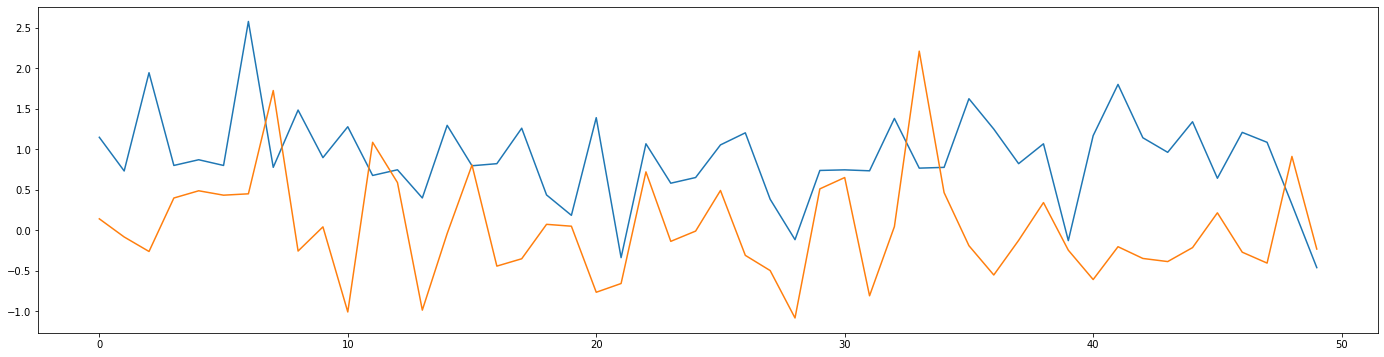

In [51]:
nbr = 50
pred = list(test_result.true_prediction)
true = list(test_result.retard_moyen_arrivee)
plt.figure(figsize=(24,6))
plt.plot(range(nbr), pred[:nbr])
plt.plot(range(nbr), true[:nbr])

In [52]:
erreur_moyenne_mse = np.sqrt(((test.retard_moyen_arrivee - test.true_prediction)**2).mean())*std + mean
erreur_moyenne_mae = (((test.retard_moyen_arrivee - test.true_prediction)).mean())*std + mean
print("Erreur mse sur le retard :", round(erreur_moyenne_mse, 2), "minutes")
print("Erreur mae sur le retard :", round(erreur_moyenne_mae, 2), "minutes")

Erreur mse sur le retard : 55.4 minutes
Erreur mae sur le retard : 21.1 minutes


### Résultats 🥇
#### Avec 4 clusters
* RF
    * Erreur sur le retard : 59,64 mse 👎 / 17,24 mae 👍
* XGB
    * Erreur sur le retard : 55,4 mse 👍 / 21,1 mae 👎

## => Environ 1h d'erreur sur le retard avec l'approche cluster 😥

#
#
#
# 2ème Approche : Embedding simple
* Feature Engineering
    * Affectation de mean_retard(gare) à chaque gare
* Régression
    * RandomForest
    * XGBoost
* Comparaison


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

path_parent = os.path.dirname(os.getcwd()) 
path = os.path.join(path_parent, "data", "preprocessed_tgv_data.csv")
df = pd.read_csv(path, delimiter=';')
data = df.reset_index(drop=True)

# 2. Clean the data
columns_to_drop = [col for col in data.columns if "commentaire" in col]
data_cleaned = data.drop(columns=columns_to_drop)

# Extract month and year from the 'date' column
data_cleaned['year'] = data_cleaned['date'].apply(lambda x: int(x.split('-')[0]))
data_cleaned['month'] = data_cleaned['date'].apply(lambda x: int(x.split('-')[1]))

# 3. Create station embeddings
mean_delay_depart = data_cleaned.groupby('gare_depart')['retard_moyen_arrivee'].mean().to_dict()
mean_delay_arrive = data_cleaned.groupby('gare_arrivee')['retard_moyen_arrivee'].mean().to_dict()

data_cleaned['gare_depart_encoded'] = data_cleaned['gare_depart'].map(mean_delay_depart)
data_cleaned['gare_arrivee_encoded'] = data_cleaned['gare_arrivee'].map(mean_delay_arrive)

# 4. Prepare data for training
X = data_cleaned[['gare_depart_encoded', 'gare_arrivee_encoded', 'duree_standard', 'year', 'month']]
y_delay = data_cleaned['retard_moyen_arrivee']
y_causes = data_cleaned[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
                         'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]

X_train, X_test, y_delay_train, y_delay_test, y_causes_train, y_causes_test = train_test_split(
    X, y_delay, y_causes, test_size=0.2, random_state=42)

# 5. Train and evaluate models : RF & XGB
# Retard = Delay
rf_delay = RandomForestRegressor(n_estimators=100, random_state=42)
rf_delay.fit(X_train, y_delay_train)
y_delay_pred_by_rf = rf_delay.predict(X_test)

xgb_delay = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,learning_rate=0.1, max_depth=3)
xgb_delay.fit(X_train, y_delay_train)
y_delay_pred_by_xgb = xgb_delay.predict(X_test)

# Causes
rf_causes = RandomForestRegressor(n_estimators=100, random_state=42)
rf_causes.fit(X_train, y_causes_train)
y_causes_pred_by_rf = rf_causes.predict(X_test)

xgb_causes = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,learning_rate=0.1, max_depth=3)
xgb_causes.fit(X_train, y_causes_train)
y_causes_pred_by_xgb = rf_causes.predict(X_test)


rmse_delay_by_rf = mean_squared_error(y_delay_test, y_delay_pred_by_rf, squared=False)
rmse_causes_by_rf = mean_squared_error(y_causes_test, y_causes_pred_by_rf, squared=False)
rmse_delay_by_xgb = mean_squared_error(y_delay_test, y_delay_pred_by_xgb, squared=False)
rmse_causes_by_xgb = mean_squared_error(y_causes_test, y_causes_pred_by_xgb, squared=False)

rmae_delay_by_rf = mean_absolute_error(y_delay_test, y_delay_pred_by_rf)
rmae_causes_by_rf = mean_absolute_error(y_causes_test, y_causes_pred_by_rf)
rmae_delay_by_xgb = mean_absolute_error(y_delay_test, y_delay_pred_by_xgb)
rmae_causes_by_xgb = mean_absolute_error(y_causes_test, y_causes_pred_by_xgb)


print("RF : RMSE delay:", rmse_delay_by_rf)
print("RF : RMSE causes :", rmse_causes_by_rf)
print('\n')
print("XGB : RMSE delay:", rmse_delay_by_xgb)
print("XGB : RMSE causes :", rmse_causes_by_xgb)
print("\n\n")
print("RF : RMAE delay:", rmae_delay_by_rf)
print("RF : RMAE causes :", rmae_causes_by_rf)
print('\n')
print("XGB : RMAE delay:", rmae_delay_by_xgb)
print("XGB : RMAE causes :", rmae_causes_by_xgb)

RF : RMSE delay: 11.759496923358451
RF : RMSE causes : 11.434843669690204


XGB : RMSE delay: 11.31035572669051
XGB : RMSE causes : 11.434843669690204



RF : RMAE delay: 7.810668368634817
RF : RMAE causes : 7.929852635597336


XGB : RMAE delay: 7.640129599466472
XGB : RMAE causes : 7.929852635597336


In [57]:
y_causes_pred = y_causes_pred_by_xgb
y_causes_pred_df = {
'prct_cause_externe' : y_causes_pred[:, 0],
'prct_cause_infra' : y_causes_pred[:, 1],
'prct_cause_gestion_trafic' : y_causes_pred[:, 2],
'prct_cause_materiel_roulant' : y_causes_pred[:, 3],
'prct_cause_gestion_gare' : y_causes_pred[:, 4],
'prct_cause_prise_en_charge_voyageurs' : y_causes_pred[:, 5],
}

y_causes_pred_df = pd.DataFrame(y_causes_pred_df)

erreur_causes = np.sqrt((y_causes_test.reset_index(drop=True) - y_causes_pred_df)**2)
print("Erreurs pour chaque causes en pourcentage")
round(erreur_causes.mean(), 1)

Erreurs pour chaque causes en pourcentage


prct_cause_externe                      10.5
prct_cause_infra                        10.1
prct_cause_gestion_trafic                8.5
prct_cause_materiel_roulant              8.3
prct_cause_gestion_gare                  4.8
prct_cause_prise_en_charge_voyageurs     5.3
dtype: float64

Erreur moyenne sur le retard : 7.64  minutes


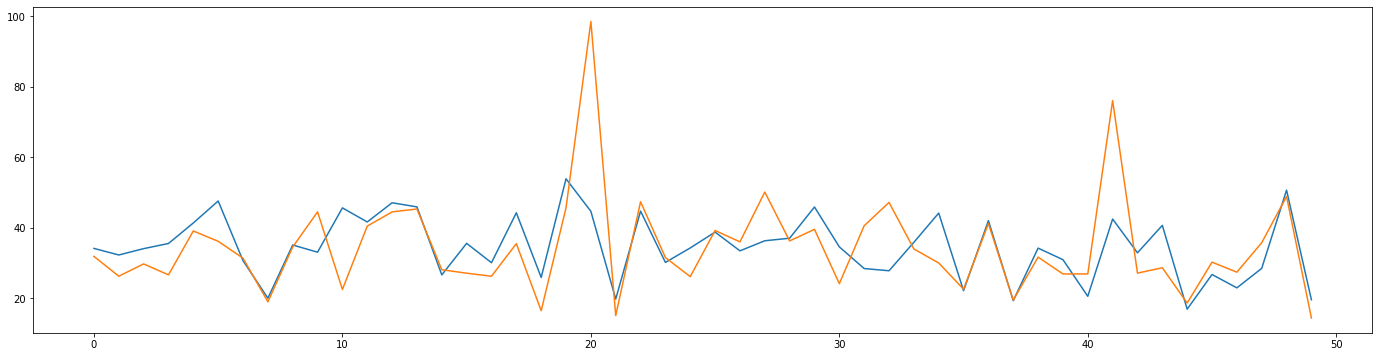

In [59]:
nbr = 50
pred = list(xgb_delay.predict(X_test)[:nbr])
true = list(y_delay_test[:nbr])
plt.figure(figsize=(24,6))
plt.plot(range(nbr), pred)
plt.plot(range(nbr), true)
print("Erreur moyenne sur le retard :", round(rmae_delay_by_xgb, 2), " minutes")

## On passe de 58 à 7 min d'erreur ! 👏👏
* Pourquoi cela fonctionne bien ?
    * La moyenne change beaucoup d'une gare à une autre mais au sein d'une même gare le retard **moyen sur le mois** reste toujours sensiblement le même selon la gare, cet embedding apporte une info représentative en moyenne consistante. Le modèle reste mauvais sur les outliers comme on peut voir sur le graphe
* Encore une fois les modèles (XGB ou RF) ne changent quasiment rien